In [1]:
import os, pathlib, shutil
import tensorflow as tf
import numpy as np

/Users/louissanna/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
original_dir = pathlib.Path("dogs-vs-cats/train")
new_base_dir = pathlib.Path("cats-vs-dogs-small")

In [3]:
def make_subset_dirs(subset_name, start_index, end_index):
    for categ in ("cat", "dog"):
        new_dir = os.path.join(new_base_dir, subset_name, categ)
        os.makedirs(new_dir, exist_ok=True)
        for i in range(start_index, end_index):
            shutil.copyfile(os.path.join(original_dir, f'{categ}.{i}.jpg'), os.path.join(new_dir, f'{categ}.{i}.jpg')) 
            
        

In [4]:
make_subset_dirs("train", 0, 1000)
make_subset_dirs("validation", 1000, 1500)
make_subset_dirs("test", 1500, 2500)

In [14]:
inputs = tf.keras.Input(shape=(180, 180, 3))

conv_base = tf.keras.applications.vgg16.VGG16(weights="imagenet", include_top=False)
conv_base.trainable = True

data_augmentations = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.2)
    
])

x = data_augmentations(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
# x = tf.keras.layers.Rescaling(scale=1./255)(x)
# x = tf.keras.layers.Conv2D(16, (3, 3), activation="relu")(x)
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)
# x = tf.keras.layers.Conv2D(32, (3, 3), activation="relu")(x)
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)
# x = tf.keras.layers.Conv2D(64, (3, 3), activation="relu")(x)
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)
# x = tf.keras.layers.Conv2D(128, (3, 3), activation="relu")(x)
# x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

58889256/58889256 [==============================] - 2s 0us/step


In [16]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 180, 180, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 180, 180, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 180, 180, 3)      0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 flatten_1 (Flatten)         (None, 12800)             0         
                                                           

In [17]:
model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

In [18]:
train_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(new_base_dir,"train"), image_size=(180, 180), batch_size=32)
validation_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(new_base_dir,"validation"), image_size=(180, 180), batch_size=32)
test_dataset = tf.keras.utils.image_dataset_from_directory(os.path.join(new_base_dir,"test"), image_size=(180, 180), batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [19]:
for data_batch, labels_batch in train_dataset:
    print(data_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [21]:
#callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath="convnet_from_scratch.keras", save_best_only=True, monitor="val_loss")]
callbacks=[]
history = model.fit(train_dataset, epochs=5, validation_data=validation_dataset, callbacks=callbacks)

Epoch 1/5
63/63 [==============================] - 498s 8s/step - loss: 6783.6675 - accuracy: 0.5025 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 2/5
10/63 [===>..........................] - ETA: 7:12 - loss: 0.6932 - accuracy: 0.4719

KeyboardInterrupt: 

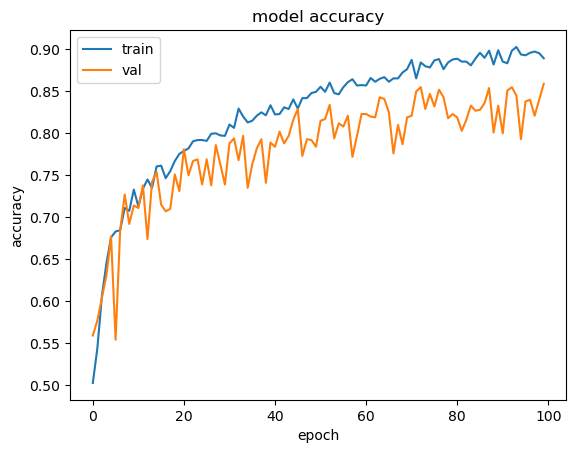

In [13]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()